In [1]:
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import json

# scraping
from bs4 import BeautifulSoup
import urllib.request

# scale figures
scale_factor = 2
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*4

In [2]:
data_path = 'data/iowa upper/cb_2017_19_sldu_500k.shp'
shapes = gp.GeoDataFrame.from_file(data_path)

print(shapes.head())

  STATEFP SLDUST        AFFGEOID  GEOID NAME LSAD   LSY       ALAND    AWATER  \
0      19    015  610U500US19015  19015   15   LU  2016  2018444563  10397350   
1      19    011  610U500US19011  19011   11   LU  2016  5654806346  26648063   
2      19    028  610U500US19028  19028   28   LU  2016  5891550986  88897367   
3      19    044  610U500US19044  19044   44   LU  2016  2870151776  89385250   
4      19    037  610U500US19037  19037   37   LU  2016  1983473342  21803055   

                                            geometry  
0  POLYGON ((-93.581052 41.780457, -93.580873 41....  
1  POLYGON ((-96.01981699999999 41.48802999999999...  
2  POLYGON ((-92.08156199999999 42.994198, -92.08...  
3  POLYGON ((-91.48581999999999 41.220666, -91.48...  
4  POLYGON ((-91.64693699999999 41.723402, -91.64...  


In [3]:
# voting records  https://votesmart.org/bills/IA/2018/2#.WvTmyZch200
# senate   https://votesmart.org/bill/votes/62842#.WvTzNpch200
# house  https://votesmart.org/bill/votes/62843#.WvTzO5ch200
# senate concurrence  https://votesmart.org/bill/votes/62844#.WvTzQpch200


# get votes
target_url = 'https://votesmart.org/bill/votes/62844#.WvXeuZch200'
with urllib.request.urlopen(target_url) as response:
    page = response.read()
    soup = BeautifulSoup(page, 'html.parser')
    vote_table = soup.table
    table_rows = vote_table.find_all('tr')
    table_rows.pop(0) # first row is headers, throw away
    
vote_record = []
    
offset = 1 # 1 row for the headers
for row in table_rows:
    columns = row.find_all('td')
    
    name_info = columns[2].span
    name_parts = name_info.find_all('span')
    name = ""
    for part in name_parts:
        name = name + part.text + ' '
    
    district = columns[1].text
    vote = columns[4].text
    party = columns[3].text
    votesmart_page = 'www.votesmart.org' + str(columns[2].a['href'])
    
    vote_object = {"district":district, "name":name, "vote":vote, "party":party, "votesmart_page":votesmart_page}
    vote_record.append(vote_object)

# store for later use
target_path = 'data/SF359 senate vote record.json'
with open(target_path, 'w') as outfile:  
    json.dump(vote_record, outfile)
    
print(vote_record)
    

[{'district': '1', 'name': 'Sen. David J. Johnson ', 'vote': 'Yea', 'party': 'Independent', 'votesmart_page': 'www.votesmart.org/candidate/17990/david-johnson'}, {'district': '2', 'name': 'Sen. Randy Feenstra ', 'vote': 'Yea', 'party': 'Republican', 'votesmart_page': 'www.votesmart.org/candidate/103301/randy-feenstra'}, {'district': '3', 'name': 'Sen. Jim Carlin ', 'vote': 'Yea', 'party': 'Republican', 'votesmart_page': 'www.votesmart.org/candidate/168690/jim-carlin'}, {'district': '4', 'name': 'Sen. Dennis Guth ', 'vote': 'Yea', 'party': 'Republican', 'votesmart_page': 'www.votesmart.org/candidate/137900/dennis-guth'}, {'district': '5', 'name': 'Sen. Tim Kraayenbrink ', 'vote': 'Yea', 'party': 'Republican', 'votesmart_page': 'www.votesmart.org/candidate/151155/tim-kraayenbrink'}, {'district': '6', 'name': 'Sen. Mark Segebart ', 'vote': 'Yea', 'party': 'Republican', 'votesmart_page': 'www.votesmart.org/candidate/86078/mark-segebart'}, {'district': '7', 'name': 'Sen. Rick Bertrand ', 'v

warning...
list index out of range


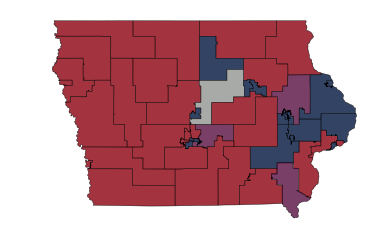

In [13]:
# color state districts based on vote record 
plt.figure()
ax = plt.gca()

for idx in range(shapes.shape[0]):
    
    district_id = shapes.loc[idx,'NAME']
    try:
        matching_record = [record for record in vote_record if record['district']==district_id][0]    
        if matching_record['vote']=='Yea':
            plot_color = 'xkcd:crimson'
        elif matching_record['vote']=='Nay':
            plot_color = 'xkcd:navy'
        else:
            plot_color = 'xkcd:plum'

        shapes.loc[[idx],'geometry'].plot(ax=ax, alpha=0.8, linewidth=0.5, edgecolor='black',facecolor=plot_color)
        
    except Exception as e: # no data
        print('warning...')
        print(e)
        
        plot_color='xkcd:grey' 
        shapes.loc[[idx],'geometry'].plot(ax=ax, alpha=0.8, linewidth=0.5, edgecolor='black',facecolor=plot_color)

    

#plt.axis('scaled')
plt.axis('off')
plt.savefig("iowa_senate_SF359.svg")
plt.show()

